In [1]:
%matplotlib inline
import torch
import random
from d2l import torch as d2l

In [ ]:
def synthetic_data(w, b, num):  #@save
    """ y = Xw + b + noise """
    X = torch.normal(0, 1, (num, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)

    return X, y.reshape((-1, 1))

In [3]:
w_true = torch.tensor([2, -3.4])
b_true = 4.2

In [4]:
features, labels = synthetic_data(w_true, b_true, 1000)
features, labels
features.size(), labels.size()  # len(features) = 1000

(torch.Size([1000, 2]), torch.Size([1000, 1]))

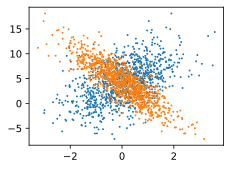

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 0].detach().numpy(), labels.detach().numpy(), 1);
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

In [ ]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        # print(indices[i: min(i + batch_size, num_examples)])
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])

        yield features[batch_indices], labels[batch_indices]

In [7]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, "\n", y)
    break

tensor([[ 2.2474e-01, -1.6846e-02],
        [ 2.1910e+00, -1.4794e+00],
        [-6.9055e-01,  1.6936e+00],
        [-1.6343e-01, -7.7201e-02],
        [-3.5299e-01, -1.6902e+00],
        [-1.3672e-01,  1.2257e-01],
        [ 3.1058e-04,  1.0617e+00],
        [ 1.1048e+00, -3.0040e-01],
        [ 8.8144e-01,  1.4193e-01],
        [ 5.3732e-01,  3.0781e-01]]) 
 tensor([[ 4.6982],
        [13.6399],
        [-2.9243],
        [ 4.1450],
        [ 9.2199],
        [ 3.5160],
        [ 0.5978],
        [ 7.4365],
        [ 5.4901],
        [ 4.2129]])


## Linear Regression

$$
\mathbf{y} = \mathbf{X} \cdot \mathbf{w} + b
$$

In [8]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [9]:
def squared_loss(y_hat, y):  #@save
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

$$
\theta := \theta - \eta \cdot \dfrac{1}{B} \nabla_{\theta}{L(\theta)}
$$

In [10]:
def sgd(params, lr, batch_size):
    """ Small-batch stochastic gradient descent """
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [11]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)  # enable the automatic differentiation function

In [12]:
## Training
lr = 0.02
iter_num = 10
for i in range(iter_num):
    for X, y in data_iter(batch_size, features, labels):
        loss = squared_loss(linreg(X, w, b), y)
        loss.sum().backward()
        sgd([w, b], lr, batch_size)

    with torch.no_grad():
        train_loss = squared_loss(linreg(features, w, b), labels)
        print(f"iter: {i + 1:2d}, loss: {float(train_loss.mean()):f}")

iter:  1, loss: 0.292123
iter:  2, loss: 0.005485
iter:  3, loss: 0.000158
iter:  4, loss: 0.000053
iter:  5, loss: 0.000050
iter:  6, loss: 0.000050
iter:  7, loss: 0.000050
iter:  8, loss: 0.000050
iter:  9, loss: 0.000050
iter: 10, loss: 0.000050


In [13]:
print(f"Estimation error of w: {w_true - w.reshape(w_true.shape)}")
print(f"Estimation error of b: {b_true - b}")

Estimation error of w: tensor([0.0004, 0.0004], grad_fn=<SubBackward0>)
Estimation error of b: tensor([0.0002], grad_fn=<RsubBackward1>)


## Simple Implementation

In [14]:
import numpy as np
from torch import nn
from torch.utils import data

In [15]:
features, labels = synthetic_data(w_true, b_true, 1000)

In [16]:
def load_array(data_arr, batch_size, is_train=True):  #@save
    dataset = data.TensorDataset(*data_arr)

    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [28]:
bathc_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[ 0.5853, -0.0334],
         [-0.4706, -0.6635],
         [-2.0026, -0.2738],
         [-0.2249, -1.4573],
         [-0.2474,  0.1310],
         [ 0.8058, -0.5503],
         [-0.8132, -1.8727],
         [-0.9422, -1.8131],
         [ 1.4189,  0.2202],
         [-0.2460,  0.1500]]),
 tensor([[5.4954],
         [5.5227],
         [1.1246],
         [8.6912],
         [3.2444],
         [7.6915],
         [8.9521],
         [8.4862],
         [6.2754],
         [3.2050]])]

In [18]:
net = nn.Sequential(nn.Linear(2, 1))
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [19]:
loss_func = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.02)

In [26]:
iter_num = 10
for i in range(iter_num):
    for X, y in data_iter:
        loss = loss_func(net(X), y)
        trainer.zero_grad()
        loss.backward()
        trainer.step()
    loss = loss_func(net(features), labels)
    print(f"iter: {i + 1:2d}, loss: {loss:f}")

iter:  1, loss: 0.000101
iter:  2, loss: 0.000101
iter:  3, loss: 0.000101
iter:  4, loss: 0.000101
iter:  5, loss: 0.000101
iter:  6, loss: 0.000101
iter:  7, loss: 0.000101
iter:  8, loss: 0.000101
iter:  9, loss: 0.000101
iter: 10, loss: 0.000101


In [27]:
w = net[0].weight.data
b = net[0].bias.data
print(f"Estimation error of w: {w_true - w.reshape(w_true.shape)}")
print(f"Estimation error of b: {b_true - b}")

Estimation error of w: tensor([0.0009, 0.0004])
Estimation error of b: tensor([0.0004])
